In [7]:
#Build & Train the LSTM Autoencoder
import numpy as np
X_train = np.load("../data/X_train.npy")

In [5]:
#Model Building

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Input shape
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# Encoder
inputs = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
encoded = RepeatVector(timesteps)(encoded)

# Decoder
decoded = LSTM(64, activation='relu', return_sequences=True)(encoded)
decoded = TimeDistributed(Dense(n_features))(decoded)

# Autoencoder model
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


/Users/software/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 5)          │           325 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,269 (200.27 KB)

 Trainable params: 51,269 (200.27 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = autoencoder.fit(
    X_train,
    X_train,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    shuffle=True
)


Epoch 1/5
44680/44680 ━━━━━━━━━━━━━━━━━━━━ 567s 13ms/step - loss: 3.9162e-05 - val_loss: 8.4526e-06
Epoch 2/5
44680/44680 ━━━━━━━━━━━━━━━━━━━━ 542s 12ms/step - loss: 9.2012e-06 - val_loss: 6.0215e-06
Epoch 3/5
44680/44680 ━━━━━━━━━━━━━━━━━━━━ 578s 13ms/step - loss: 6.3058e-06 - val_loss: 7.0480e-06
Epoch 4/5
44680/44680 ━━━━━━━━━━━━━━━━━━━━ 547s 12ms/step - loss: 4.8550e-06 - val_loss: 3.5183e-06
Epoch 5/5
44680/44680 ━━━━━━━━━━━━━━━━━━━━ 497s 11ms/step - loss: 3.9843e-06 - val_loss: 2.9487e-06


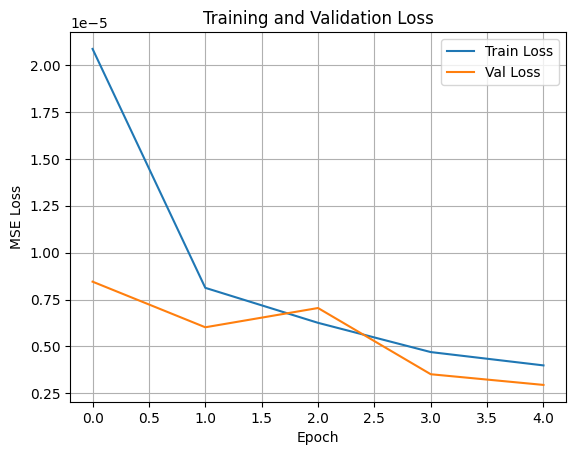

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
#Test data including fraud

In [12]:
# Load full dataset again
import pandas as pd
df = pd.read_csv("../data/PS_20174392719_1491204439457_log.csv")

# Keep same features
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
df_filtered = df[features + ['isFraud']].copy()
df_filtered.fillna(0, inplace=True)

# Normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_filtered[features] = scaler.fit_transform(df_filtered[features])

# Create sequences including both fraud and non-fraud
SEQUENCE_LENGTH = 10

def create_sequences_with_labels(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length][features].values
        label = data.iloc[i + seq_length]['isFraud']  # label for the last txn in sequence
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

X_test, y_test = create_sequences_with_labels(df_filtered, SEQUENCE_LENGTH)
print("Test sequences:", X_test.shape)
print("Test labels:", y_test.shape)
 

Test sequences: (6362610, 10, 5)
Test labels: (6362610,)


In [13]:
# Predict reconstruction
X_pred = autoencoder.predict(X_test)
mse = np.mean(np.mean(np.square(X_test - X_pred), axis=2), axis=1)


198832/198832 ━━━━━━━━━━━━━━━━━━━━ 216s 1ms/step


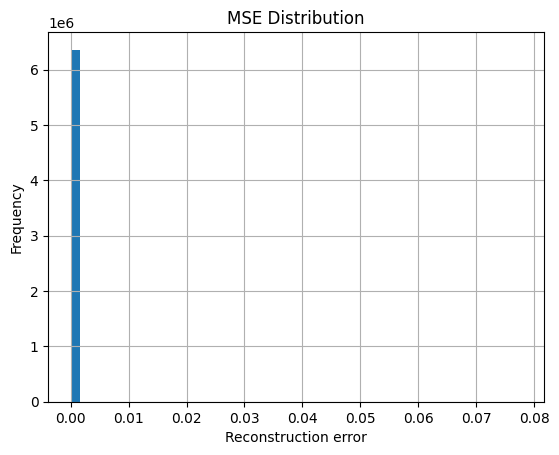

Threshold: 8.668199246200972e-06


In [14]:
# Determine Threshold
import matplotlib.pyplot as plt

plt.hist(mse, bins=50)
plt.xlabel("Reconstruction error")
plt.ylabel("Frequency")
plt.title("MSE Distribution")
plt.grid(True)
plt.show()

# Set threshold (adjust based on plot)
threshold = np.percentile(mse, 95)  # Top 5% as anomalies
print("Threshold:", threshold)


In [15]:
#Evaluate Anomaly Detection

y_pred = (mse > threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


[[6040385  314014]
 [   4094    4117]]
              precision    recall  f1-score   support

         0.0     0.9993    0.9506    0.9743   6354399
         1.0     0.0129    0.5014    0.0252      8211

    accuracy                         0.9500   6362610
   macro avg     0.5061    0.7260    0.4998   6362610
weighted avg     0.9980    0.9500    0.9731   6362610



In [16]:
print(confusion_matrix(y_test, y_pred))

[[6040385  314014]
 [   4094    4117]]
